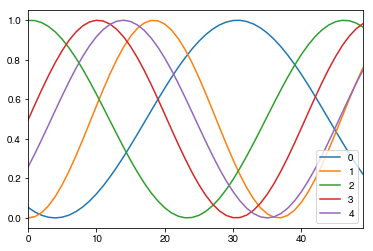

In [1]:
# From here: http://www.rricard.me/machine/learning/generative/adversarial/networks/keras/tensorflow/2017/04/05/gans-part2.html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
def sample_data(n_samples=10000, x_vals=np.arange(0, 5, .1), max_offset=100, mul_range=[1, 2]):
    vectors = []
    for i in range(n_samples):
        offset = np.random.random() * max_offset
        mul = mul_range[0] + np.random.random() * (mul_range[1] - mul_range[0])
        vectors.append(
            np.sin(offset + x_vals * mul) / 2 + .5
        )
    return np.array(vectors)

ax = pd.DataFrame(np.transpose(sample_data(5))).plot()

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Activation
from keras.optimizers import SGD
def get_generative(G_in, dense_dim=200, out_dim=50, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

G_in = Input(shape=[10])
G, G_out = get_generative(G_in)
G.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               2200      
_________________________________________________________________
activation_3 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                10050     
Total params: 12,250
Trainable params: 12,250
Non-trainable params: 0
_________________________________________________________________


In [10]:
#from keras.models import 
from keras.layers import Flatten, Dropout, Conv1D, Reshape
from keras.optimizers import Adam
def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=50, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

D_in = Input(shape=[50])
D, D_out = get_discriminative(D_in)
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 50)                0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 50, 1)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 50)            300       
_________________________________________________________________
dropout_2 (Dropout)          (None, 46, 50)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2300)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                115050    
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 102       
Total para

In [11]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([10])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 10)                0         
_________________________________________________________________
model_2 (Model)              (None, 50)                12250     
_________________________________________________________________
model_4 (Model)              (None, 2)                 115452    
Total params: 127,702
Trainable params: 12,250
Non-trainable params: 115,452
_________________________________________________________________


In [12]:
def sample_data_and_gen(G, noise_dim=10, n_samples=10000):
    XT = sample_data(n_samples=n_samples)
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y

def pretrain(G, D, noise_dim=10, n_samples=10000, batch_size=32):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)

pretrain(G, D)

Epoch 1/1
20000/20000 [==============================] - 3s 171us/step - loss: 0.0073


In [14]:
from tqdm import tqdm

def sample_noise(G, noise_dim=10, n_samples=10000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

def train(GAN, G, D, epochs=500, n_samples=10000, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss

d_loss, g_loss = train(GAN, G, D, verbose=True)

 10%|█         | 50/500 [01:49<15:22,  2.05s/it]

Epoch #50: Generative Loss: 3.14088749886, Discriminative Loss: 0.824670732021


 20%|██        | 100/500 [03:57<17:08,  2.57s/it]

Epoch #100: Generative Loss: 2.18502020836, Discriminative Loss: 0.178218439221


 30%|███       | 150/500 [06:04<15:48,  2.71s/it]

Epoch #150: Generative Loss: 3.92912268639, Discriminative Loss: 0.0912817940116


 40%|████      | 200/500 [08:07<09:55,  1.98s/it]

Epoch #200: Generative Loss: 5.55012321472, Discriminative Loss: 0.0180302895606


 50%|█████     | 250/500 [09:55<11:19,  2.72s/it]

Epoch #250: Generative Loss: 4.19741344452, Discriminative Loss: 0.075765684247


 60%|██████    | 300/500 [11:49<08:39,  2.60s/it]

Epoch #300: Generative Loss: 3.44129681587, Discriminative Loss: 0.0633649677038


 70%|███████   | 350/500 [13:41<05:43,  2.29s/it]

Epoch #350: Generative Loss: 3.41362810135, Discriminative Loss: 0.0642166286707


 80%|████████  | 400/500 [15:36<03:49,  2.29s/it]

Epoch #400: Generative Loss: 3.70319461823, Discriminative Loss: 0.0432508103549


 90%|█████████ | 450/500 [17:42<02:15,  2.71s/it]

Epoch #450: Generative Loss: 4.23184871674, Discriminative Loss: 0.0356241352856


100%|██████████| 500/500 [19:33<00:00,  2.06s/it]

Epoch #500: Generative Loss: 7.18382501602, Discriminative Loss: 0.017808817327


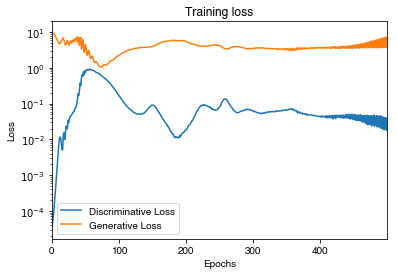

In [15]:
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

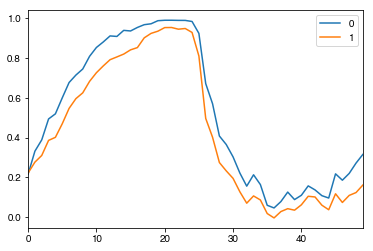

In [16]:
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()

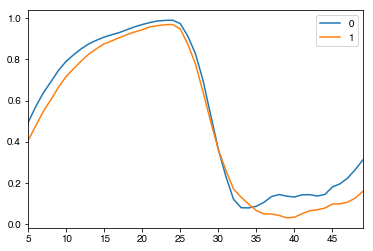

In [17]:
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).rolling(5).mean()[5:].plot()